# kaggle 해커톤 . 6-2조
- 프로젝트 링크:
https://www.kaggle.com/c/competitive-data-science-predict-future-sales


## team
- 6-2조
- 이상국, 강명훈, 장선우

## 일정
### 1일차
- ~ : 각자 문제 및 데이터 파악
- 11:30 ~ : data 및 문제 관련 정의 (화상)
- ~ : 각자 진행
- 14:30 ~ : 진행 과정 토의1(화상) ex) 데이터 전처리, 모델정의
- ~ : 각자 진행   
- 17:00 ~ : 진행 과정 토의2(화상) , ex) 모델평가, 그리드서치, 앙상블, 모델개선 등..
- ~ 각자 진행   
<br/><br/>

### 2일차
- 10:00 ~ : 진행과정 토의3(화상),open meet
- ~ 각자 진행   
- 11:30 ~ : 제출 전 정리 미팅, 최고 스코어 도출
- ~ 각자 진행 또는 협업
- 14:00 ~ : 최종 제출

## 대회
- 2020.08.27(목)~2020.08.28(금) PM 2:00까지
- 캐글 Public Score 중 최고점을 슬랙 대회 채널에 jupyter notebook 파일과 함께 제출
- 제출 파일은 jupyter notebook이고,
- 형식은 Exploration 노드 과제 제출 형식과 동일합니다. (결과 출력, 로그 및 주요사항 reporting)

## 문제파악


### 디스크립션
- 러시아 최대 소프트웨어 회사 중 하나 인 1C Company 에서 친절하게 제공 한 일일 판매 데이터로 구성된 까다로운 시계열 데이터 세트


### file
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

### filed 

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- date_block_num==> 월 index data
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### 문제 정의
- 다음 달의 모든 제품 및 매장에 대한 총 매출을 예측

# library import

In [7]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



#model 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# hyper pram tuning library
from sklearn.model_selection import GridSearchCV

#time
import time

# data import

In [8]:
# data path set

data_dir = "./data"
train_data_path = join(data_dir, 'sales_train.csv') #train data
test_data_path = join(data_dir, 'test.csv') #test data

submission_path = join(data_dir, 'sample_submission.csv') #제출파일

categories_data_path = join(data_dir, 'item_categories.csv') #카테고리: 네임, 카테고리 아이디
items_path = join(data_dir, 'items.csv') # 아이템: 이름, id,  카테고리id
shops_path = join(data_dir, 'shops.csv') # 매장명: 매장명, id

# data import
origin_train = pd.read_csv(train_data_path)
origin_test = pd.read_csv(test_data_path)

submission_path = join(data_dir, 'sample_submission.csv') #제출파일

# 
categories= pd.read_csv(categories_data_path)
items = pd.read_csv(items_path)
shops = pd.read_csv(shops_path)



# data 파악

In [9]:
origin_train.shape

(2935849, 6)

In [10]:
origin_train.dtypes # column data type 조회

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [11]:
origin_train.head()
# 월 정보 index column

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [12]:
origin_test.head() # test data

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [13]:
categories.head() # 카테고리 파일

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [14]:
shops.head() # 매장 파일

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [15]:
items.head() # 아이템 제품 파일

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [16]:
## 매장별 월별 데이터

# data preprocessing

In [17]:
##
origin_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [18]:
train = origin_train.copy()
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## 결측 데이터 숙청

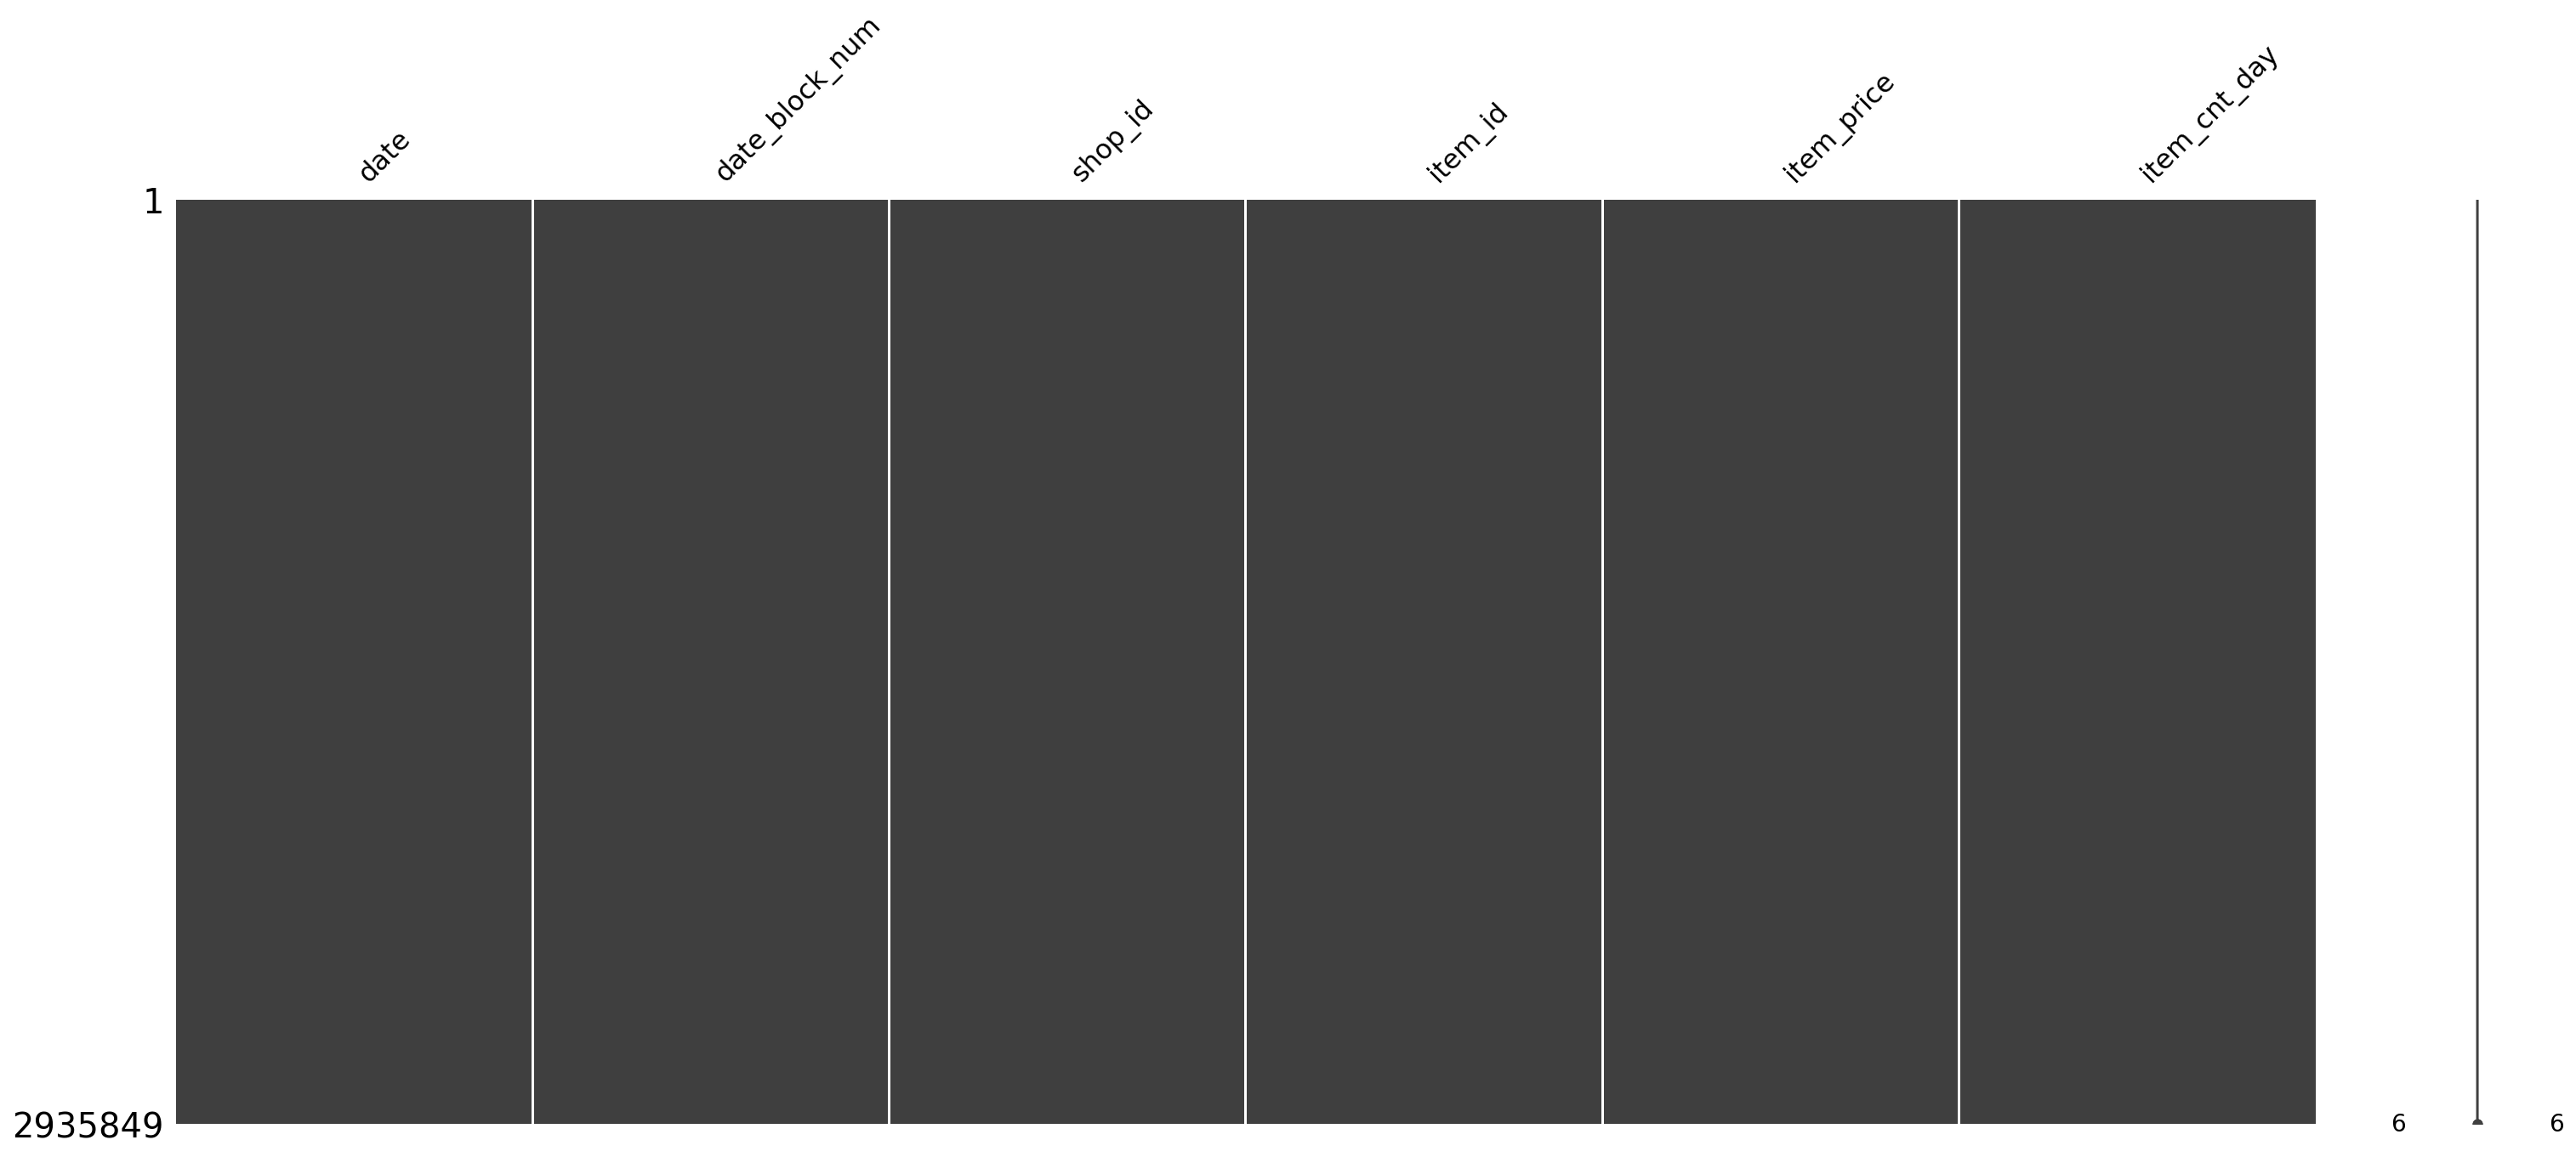

In [19]:
# 결측데이터 graph
msno.matrix(train)

In [20]:
print("------train data 결측------")
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))
print("\n------test data 결측-------")
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

------train data 결측------
date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0

------test data 결측-------
date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0


In [21]:
#결측 데이더 없~~넹...

## 중복 데이터 숙청

In [22]:
train[train.duplicated()]
#6개 중복 데이터

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [23]:

def find_by_date_shopid_itemid(date, sid, iid):
    return train[(train['date'] == date)&(train['shop_id']==sid)&(train['item_id']==iid)]

d0 = find_by_date_shopid_itemid('05.01.2013', 54, 20130)
d1 = find_by_date_shopid_itemid('23.02.2014', 50, 3423)
d2 = find_by_date_shopid_itemid('23.03.2014', 21, 3423)
d3 = find_by_date_shopid_itemid('01.05.2014', 50, 3423)
d4 = find_by_date_shopid_itemid('12.07.2014', 25, 3423)
d5 = find_by_date_shopid_itemid('31.12.2014', 42, 21619)
print (d0)
print (d1)
print (d2)
print (d3)
print (d4)

             date  date_block_num  shop_id  item_id  item_price  item_cnt_day
76961  05.01.2013               0       54    20130       149.0           1.0
76962  05.01.2013               0       54    20130       149.0           1.0
               date  date_block_num  shop_id  item_id  item_price  \
1435365  23.02.2014              13       50     3423       999.0   
1435367  23.02.2014              13       50     3423       999.0   

         item_cnt_day  
1435365           1.0  
1435367           1.0  
               date  date_block_num  shop_id  item_id  item_price  \
1496765  23.03.2014              14       21     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   

         item_cnt_day  
1496765           1.0  
1496766           1.0  
               date  date_block_num  shop_id  item_id  item_price  \
1671872  01.05.2014              16       50     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   

In [24]:
#중복 데이터 숙청.
train.drop_duplicates(inplace=True)
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## 이상치

### cnt_day , price

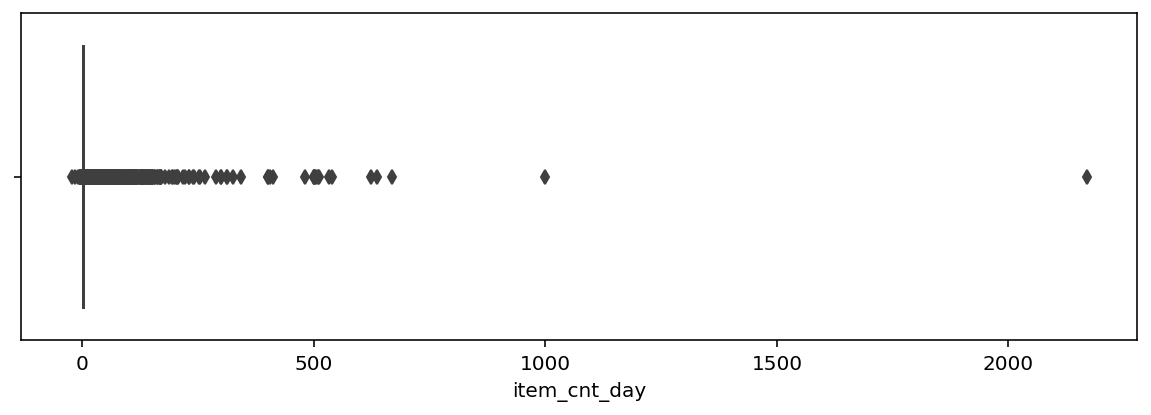

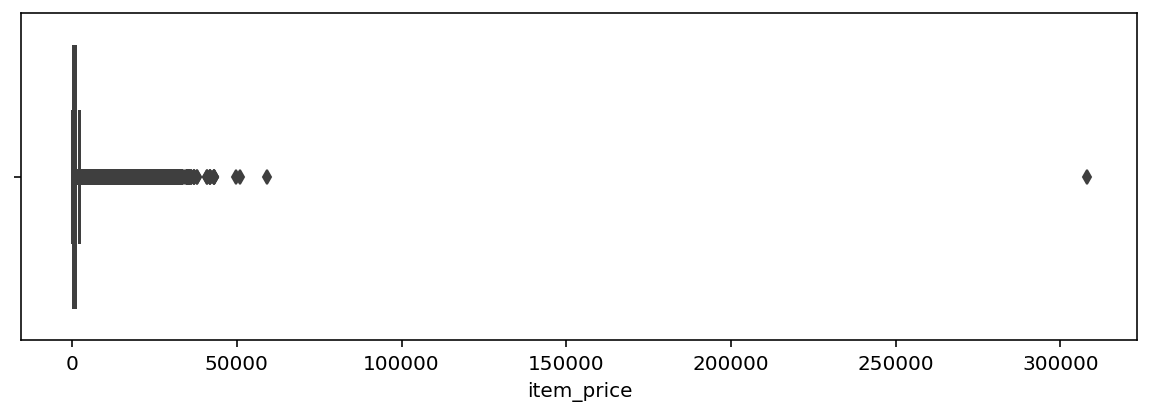

In [25]:
# 개수와 가격

plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=train);


In [26]:
#
train = train[train.item_cnt_day < 500]
train = train[train.item_price < 50000]
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


# 여기부터 capy cat

## data 전처리(계속)

### 이상치 제거 계속

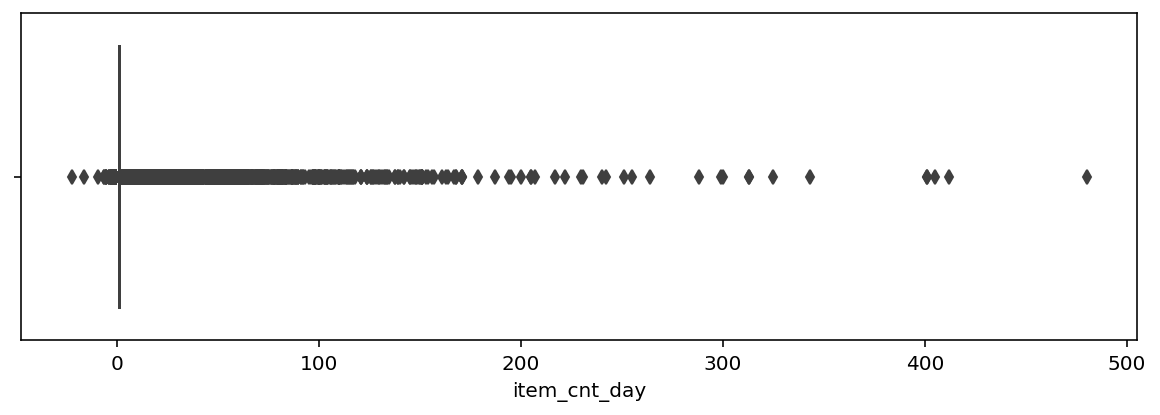

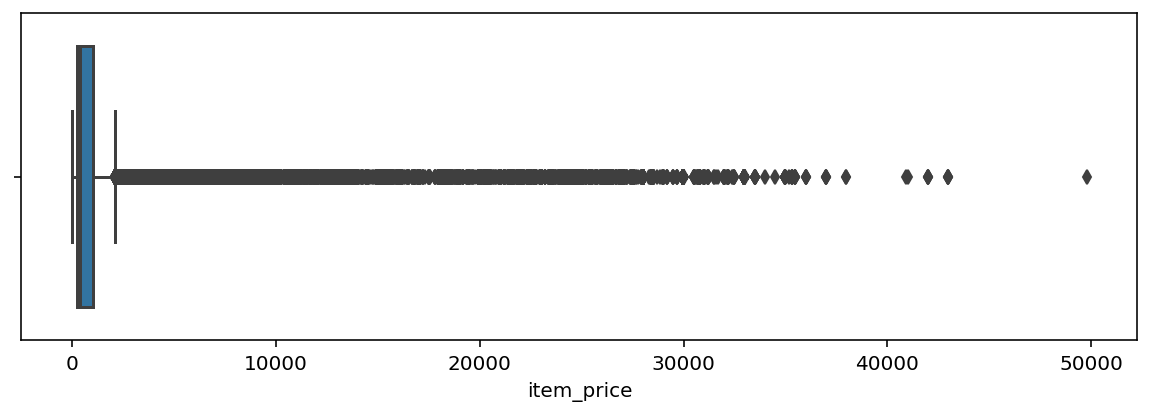

In [27]:

plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=train);

### data  (..)
 - 한 번에 요약된 통계 결과를 반환, 시리즈 혹은 데이터프레임의 각 열에 대한 요약 통계 

In [28]:
# data standardization
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935826e+06,2.935826e+06,2.935826e+06,2.935826e+06,2.935826e+06
mean,1.456986e+01,3.300178e+01,1.019721e+04,8.907121e+02,1.239344e+00
std,9.422973e+00,1.622696e+01,6.324294e+03,1.719911e+03,1.923299e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,4.978200e+04,4.800000e+02


In [29]:
train = train[train.item_cnt_day >= 0]
train = train[train.item_price >= 0]

### Shops name 수정ㅡ

In [30]:
shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [31]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [32]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

In [33]:
shops.head(2)

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск


In [34]:
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [35]:
# 수치 데이터가 아닌 문자 데이터는 데이터 분석이 번거롭다. 따라서 문자 데이터를 모두 수치 데이터로 Encoding하는 작업이 필요하다.

###  shops Enconding

In [36]:
shops.city.value_counts()

Москва              13
Якутск               4
Тюмень               3
Воронеж              3
РостовНаДону         3
СПб                  2
Самара               2
Красноярск           2
Жуковский            2
Казань               2
Н.Новгород           2
Новосибирск          2
Уфа                  2
Выездная             1
Ярославль            1
Балашиха             1
Цифровой             1
Курск                1
Волжский             1
Вологда              1
Мытищи               1
Коломна              1
СергиевПосад         1
Калуга               1
Чехов                1
Интернет-магазин     1
Химки                1
Сургут               1
Томск                1
Омск                 1
Адыгея               1
Name: city, dtype: int64

In [37]:
from sklearn.preprocessing import LabelEncoder
city_encoder = LabelEncoder()
shops['city_code'] = city_encoder.fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code']]
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### Item category Encoding

In [38]:
type_encoder = LabelEncoder()
categories['split_name'] = categories['item_category_name'].str.split(' - ')
categories['type'] = categories['split_name'].map(lambda x: x[0].strip())
categories['type_code'] = type_encoder.fit_transform(categories['type'])

In [39]:

subtype_encoder = LabelEncoder()
categories['subtype'] = categories['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories['subtype_code'] = subtype_encoder.fit_transform(categories['subtype'])
categories = categories[['item_category_id', 'type_code', 'subtype_code']]

In [40]:
categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


### item Encoding

In [41]:
items.drop(['item_name'], axis=1, inplace=True)

In [42]:
items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


In [43]:
shops.head(2)

,shop_id,city_code
0,0,29
1,1,29


In [44]:

categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


In [45]:
items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


### test 데이터 인코딩

In [46]:
test = origin_test.copy()

In [47]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [48]:
test.shop_id.value_counts()

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
10    5100
7     5100
6     5100
5     5100
4     5100
3     5100
31    5100
34    5100
35    5100
36    5100
57    5100
56    5100
55    5100
53    5100
52    5100
50    5100
49    5100
48    5100
47    5100
46    5100
45    5100
44    5100
42    5100
41    5100
39    5100
38    5100
37    5100
2     5100
Name: shop_id, dtype: int64

In [49]:
len(set(test.item_id) - set(train.item_id))

363

In [50]:
len(test) == 42*5100
#df_test에는 있지만 df_train에는 없는 item_id가 총 363개 있다. 
#이는 df_train에 모든 종류의 item이 있지는 않다는 것을 뜻한다. 363개의 item에 대해서는 0개가 판매된 것으로 예측해야한다.

True


### 'date_block_num', 'shop_id', 'item_id'로 구성된 Matrix 만들기

In [51]:
num_date_block_num = len(train.date_block_num.value_counts())
num_date_block_num

34

In [52]:
import time
import itertools

ts = time.time()
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
time.time()-ts

6.8303892612457275

In [53]:

matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


In [54]:
sales = train[train.date_block_num == 1]

In [55]:
sales.shop_id.unique()

array([50, 47, 51, 52, 42, 46, 43, 54, 56, 59,  7, 53, 16, 18, 19, 14, 15,
       13, 23, 24, 21, 25, 22,  4,  3,  5,  1,  2,  6,  0,  8, 12, 10, 31,
       32, 35, 44, 41, 45, 37, 38, 26, 27, 29, 30, 28])

In [56]:
sales.item_id.unique()

array([ 3880,  4128,  4124, ..., 12885, 12791, 13433])

In [57]:
list(itertools.product([1], sales.shop_id.unique(), sales.item_id.unique()))

[(1, 50, 3880),
 (1, 50, 4128),
 (1, 50, 4124),
 (1, 50, 3879),
 (1, 50, 3885),
 (1, 50, 3950),
 (1, 50, 4163),
 (1, 50, 3897),
 (1, 50, 3941),
 (1, 50, 3959),
 (1, 50, 4036),
 (1, 50, 3983),
 (1, 50, 3993),
 (1, 50, 4127),
 (1, 50, 3890),
 (1, 50, 4115),
 (1, 50, 3878),
 (1, 50, 3834),
 (1, 50, 3850),
 (1, 50, 3851),
 (1, 50, 3788),
 (1, 50, 3805),
 (1, 50, 3869),
 (1, 50, 3870),
 (1, 50, 3871),
 (1, 50, 4164),
 (1, 50, 4244),
 (1, 50, 4245),
 (1, 50, 4248),
 (1, 50, 4249),
 (1, 50, 4251),
 (1, 50, 4266),
 (1, 50, 4092),
 (1, 50, 4282),
 (1, 50, 4241),
 (1, 50, 4227),
 (1, 50, 4240),
 (1, 50, 3508),
 (1, 50, 3328),
 (1, 50, 3321),
 (1, 50, 3322),
 (1, 50, 3360),
 (1, 50, 3362),
 (1, 50, 3366),
 (1, 50, 3367),
 (1, 50, 3320),
 (1, 50, 3325),
 (1, 50, 3326),
 (1, 50, 3327),
 (1, 50, 3476),
 (1, 50, 3702),
 (1, 50, 3705),
 (1, 50, 3718),
 (1, 50, 3698),
 (1, 50, 3719),
 (1, 50, 3743),
 (1, 50, 3745),
 (1, 50, 3622),
 (1, 50, 3624),
 (1, 50, 3693),
 (1, 50, 3490),
 (1, 50, 3371),
 (1, 50,

### train의 Groupby를 통한 Monthly Sales 구하기

In [58]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


In [59]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [60]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00


In [61]:
## 그룹핑 및 월별 합계
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})

In [62]:
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0

In [63]:

group.columns = ['item_cnt_month']

In [64]:

group.head()

item_cnt_month
date_block_num shop_id item_id                
0              0       32                  6.0
                       33                  3.0
                       35                  1.0
                       43                  1.0
                       51                  2.0

In [65]:
#indexing0
group.reset_index(inplace=True)

In [66]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


In [67]:
matrix = pd.merge(matrix, group, how='left')

In [68]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0


In [69]:

matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 30).astype(np.float16))
#NaN은 0으로 바꾸고, 범위를 0과 30사이로 정한다. 30이 넘어가는 수는 그다지 많지 않기 
#때문에 예측의 정확성을 위해 범위를 지정해준다. 타입도 float16으로 바꾼다.

In [70]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


### matrix에 테스트 데이터 붙이기

In [71]:
test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [72]:

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [73]:
test.head(2)

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34


In [74]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # for 34 month
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,0,19,0.0,0.0
1,0,0,27,0.0,0.0
2,0,0,28,0.0,0.0
3,0,0,29,0.0,0.0
4,0,0,32,6.0,0.0


In [75]:

matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID
11098655,34,45,18454,0.0,214195.0
11098656,34,45,16188,0.0,214196.0
11098657,34,45,15757,0.0,214197.0
11098658,34,45,19648,0.0,214198.0
11098659,34,45,969,0.0,214199.0


### matrix에 df_shops, df_items, df_item_categories merge하기

In [76]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, categories, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [77]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0.0,29,40,11,6
1,0,0,27,0.0,0.0,29,19,5,12
2,0,0,28,0.0,0.0,29,30,8,57
3,0,0,29,0.0,0.0,29,23,5,18
4,0,0,32,6.0,0.0,29,40,11,6


In [78]:

matrix[matrix['date_block_num'] == 0]

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0.0,29,40,11,6
1,0,0,27,0.0,0.0,29,19,5,12
2,0,0,28,0.0,0.0,29,30,8,57
3,0,0,29,0.0,0.0,29,23,5,18
4,0,0,32,6.0,0.0,29,40,11,6
...,...,...,...,...,...,...,...,...,...
364945,0,59,22149,0.0,0.0,30,40,11,6
364946,0,59,22151,2.0,0.0,30,40,11,6
364947,0,59,22154,1.0,0.0,30,37,11,1
364948,0,59,22160,0.0,0.0,30,40,11,6


### Matrix에 Target lags 추가

In [79]:

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [80]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

### Mean encoded features

In [81]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']

In [82]:
group.head()

,date_avg_item_cnt
date_block_num,
0,0.354980
1,0.333008
2,0.367432
3,0.287354
4,0.270996


In [83]:
group.reset_index(inplace=True)

In [84]:
group.head()

,date_block_num,date_avg_item_cnt
0,0,0.354980
1,1,0.333008
2,2,0.367432
3,3,0.287354
4,4,0.270996


### matrix에 월 평균 판매 수량 (date_avg_item_cnt) 추가하기

In [85]:

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt
0,0,0,19,0.0,0.0,29,40,11,6,NaN,NaN,NaN,NaN,NaN,0.35498
1,0,0,27,0.0,0.0,29,19,5,12,NaN,NaN,NaN,NaN,NaN,0.35498
2,0,0,28,0.0,0.0,29,30,8,57,NaN,NaN,NaN,NaN,NaN,0.35498
3,0,0,29,0.0,0.0,29,23,5,18,NaN,NaN,NaN,NaN,NaN,0.35498
4,0,0,32,6.0,0.0,29,40,11,6,NaN,NaN,NaN,NaN,NaN,0.35498


### matrix에 월 평균 판매 수량에 대한 1달 lag 추가하기

In [86]:
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')

In [87]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt,date_avg_item_cnt_lag_1
11098655,34,45,18454,0.0,214195.0,20,55,13,4,1.0,0.0,0.0,0.0,NaN,0.0,0.266846
11098656,34,45,16188,0.0,214196.0,20,64,14,44,0.0,0.0,NaN,NaN,NaN,0.0,0.266846
11098657,34,45,15757,0.0,214197.0,20,55,13,4,0.0,0.0,0.0,0.0,0.0,0.0,0.266846
11098658,34,45,19648,0.0,214198.0,20,40,11,6,0.0,0.0,0.0,0.0,NaN,0.0,0.266846
11098659,34,45,969,0.0,214199.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.266846


In [88]:

matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
11098655,34,45,18454,0.0,214195.0,20,55,13,4,1.0,0.0,0.0,0.0,NaN,0.266846
11098656,34,45,16188,0.0,214196.0,20,64,14,44,0.0,0.0,NaN,NaN,NaN,0.266846
11098657,34,45,15757,0.0,214197.0,20,55,13,4,0.0,0.0,0.0,0.0,0.0,0.266846
11098658,34,45,19648,0.0,214198.0,20,40,11,6,0.0,0.0,0.0,0.0,NaN,0.266846
11098659,34,45,969,0.0,214199.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.266846


In [89]:
### 여러가지 조합으로 lag 추가하기
- matrix에 월별 item별 평균 판매 수량(date_item_avg_item_cnt) lag 추가하기

SyntaxError: invalid syntax (<ipython-input-89-0082bf26aa4c>, line 2)

In [ ]:

group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

- matrix에 월별, shop_id별 평균 판매 수량(date_shop_avg_item_cnt) lag 추가하기

In [ ]:

group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
- matrix에 월별 category별 평균 판매 수량(date_cat_avg_item_cnt) lag 추가하기

In [ ]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

- matrix에 월별 shop별, category별 평균 판매 수량(date_shop_cat_avg_item_cnt) lag 추가하기

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

## 매출 데이터 생성(일 별)
- 가격 * 아이템 수

## 시계열 데이터 처리

## x train data 정리
- 매장별
- 월별
- 매출 : 판매수 * 가격

## y값 처리
- train 에서 y 값 도려내기
- y 값 분포 조정

In [ ]:
## 

# reference

- https://github.com/BaekKyunShin/Kaggle/blob/master/Predict_Future_Sales/Predict%20Future%20Sales.ipynb

- https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts

# test

In [ ]:
origin_train.tail()

# comment